The goal of this post is to describe how to make wordclouds using Python.

Good sources for a description of the algorithm can be found here:

- SO <http://stackoverflow.com/questions/342687/algorithm-to-implement-a-word-cloud-like-wordle>
- Wordle <http://www.wordle.net/>
- book chapter from the Wordle creator <http://static.mrfeinberg.com/bv_ch03.pdf>

We will use the Peter Norvig approach to coding: describe with English words, then implement later.

# Modelling a word cloud 

Words and weights will be modelled as strings (unicode) and floats.

We will use a rectangle based approach. So we need rectangles. Rectangles must be testable for intersection. Use a quadtree for that.

In [1]:
from copy import deepcopy as copy

def build_wordcloud(words, weights):
    """Builds a wordcloud from words and weights."""
    wordcloud = Wordcloud()
    for word, weight in sorted(zip(words, weights), key=lambda item: item[1]):
        ideal_location = place_word(wordcloud)
        location = copy(ideal_location)
        while intersection(word, weight, location, wordcloud):
            location = move_location_along_spiral(location, ideal_location)
        insert_word(word, wordcloud, location)
    return wordcloud

# class: Wordcloud, functions: place_word, move_location_along_spiral
# TODO intersection insert_word

Let's move on to placing words. The strategy described in the PDF is as follows:

>Wordle offers the user a choice of placement strategies. These strategies influence the shape and texture of the completed Wordle, by determining where each word “wants” to go. On the Wordle website, the choices are center-line and alphabetical center-line. Both strategies place words near the horizontal center-line of the playing field (not necessarily upon it, but scattered away from it by a random distribution). The alphabetical strategy sorts the words alphabetically and then distributes their preferred x coordinates across the playing field.

Here, we need to define the location datatype. As a location is just a $(x,y)$ coordinate, we will make use of the complex numbers present in Python. This will simplify vector operations further along.

In [2]:
class Location(complex):
    "A location in the (x, y) plane."
    def __repr__(self): return 'Location({}, {})'.format(self.x, self.y)
    x = property(lambda p: p.real)
    y = property(lambda p: p.imag)

Now let's implement `place_words`.

In [3]:
import random

def place_word(wordcloud):
    """Places a word according to a random center-line strategy in the wordcloud."""
    y_position = get_vertical_center(wordcloud)
    left, right = get_horizontal_bounds(wordcloud)
    x_position = random.uniform(left, right)
    return Location(x_position, y_position)

# functions get_vertical_center, get_horizontal_bounds

We now need to do some design decisions. Our wordcloud will be a class that keeps track of positioned words as rectangular bounding boxes. So we will define a class for positioned words and the wordcloud itself.

In [4]:
class PositionedWord:
    """Class that handles a word positioned on the playing field."""
    def __init__(self, location, word, fontsize):
        self.location = location
        self.word = word
        self.fontsize = fontsize
        self.bbox = compute_bbox(self)
        
# TODO compute_bbox

In [5]:
class Wordcloud:
    """Class that keeps track of the positioned words and the playing field."""
    def __init__(self, width=3, height=2):
        self.words = []
        self.width = width
        self.height = height
        
    def __repr__(self):
        print("Wordcloud (w={}, h={}, words={})".format(self.width, self.height, len(self.words)))

Now, let's implement the low level function we've just used:

In [6]:
def get_vertical_center(wordcloud):
    """Returns the vertical center of the wordcloud."""
    return wordcloud.height / 2.

In [7]:
def get_horizontal_bounds(wordcloud):
    """Returns the (x_min, x_max) bounds of the wordcloud."""
    return (0, wordcloud.width)

This being done, we now turn to moving the location along if the intersection with existing words is not empty.

In [8]:
from cmath import polar, pi, exp

def move_location_along_spiral(location, center):
    """Moves location along a spiral relative to a center."""
    FACTOR = 0.05
    r, theta = polar(location - center)
    return r * (1 + FACTOR) * exp(1j * (theta + pi * FACTOR))

Let's now move to the intersection routine. We'll do something naive by looping over existing words in the wordcloud and if the bounding box of our word is within one of the boxes of the words, we'll flag it as an intersection.

In [9]:
def intersection(word, weight, location, wordcloud):
    """Checks for intersections between word at a given location and the existing wordcloud."""
    tentative_positioning = PositionedWord(location, word, weight)
    for existing_word in wordcloud.words:
        if bbox_intersection(tentative_positioning, existing_word):
            return True
    return False

Now, let's define the function that checks if the bounding boxes intersect.

In [10]:
def bbox_intersection(tentative_positioning, existing_word):
    """Checks whether the bboxes of the two words intersect or not."""
    # check for x axis
    

#  Testing

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

We can test the spiraling here:

In [12]:
def plot_cplx(z):
    """Plots a complex number."""
    plt.plot(z.real, z.imag, 'o')

(-10, 10)

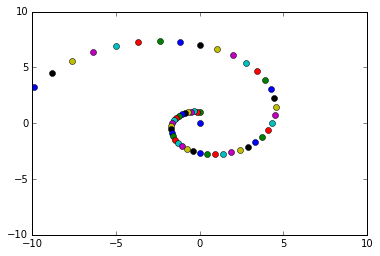

In [13]:
center = Location(0, 0)
location = Location(0, 1)
plot_cplx(center)
plot_cplx(location)
for i in range(100):
    location = move_location_along_spiral(location, center)
    plot_cplx(location)

plt.xlim(-10, 10)
plt.ylim(-10, 10)

Let's test the whole process:

In [14]:
words = "William Shakespeare  was an English poet, playwright, and actor, widely regarded as the greatest writer in the English language and the world's pre-eminent dramatist.".split(" ")

In [15]:
weigths = [1 for word in words]

In [16]:
words

['William',
 'Shakespeare',
 '',
 'was',
 'an',
 'English',
 'poet,',
 'playwright,',
 'and',
 'actor,',
 'widely',
 'regarded',
 'as',
 'the',
 'greatest',
 'writer',
 'in',
 'the',
 'English',
 'language',
 'and',
 'the',
 "world's",
 'pre-eminent',
 'dramatist.']

In [17]:
weigths

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [18]:
build_wordcloud(words, weigths)

NameError: name 'compute_bbox' is not defined

AttributeError: Unknown property xycoords

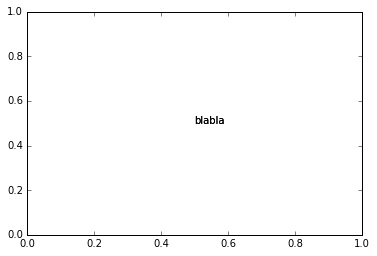

In [19]:
txt = plt.text(0.5, 0.5, "blabla")
plt.gca().add_artist(txt)
rect = plt.Rectangle((246, 162), 22.5, 10, xycoords='data')
plt.gca().add_artist(rect)

In [20]:
txt

In [21]:
txt.get_window_extent()

Bbox([[246.0, 162.0], [280.0, 172.0]])

In [22]:
txt.get_window_extent()

Bbox([[246.0, 162.0], [280.0, 172.0]])

In [23]:
plt.Rectangle((246, 162), 22.5, 10)

# Testing on autoscale 

In [24]:
import matplotlib.pyplot as plt

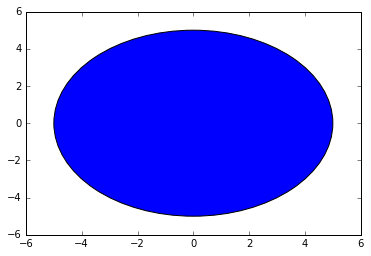

In [33]:
ax = plt.gca()
circ = plt.Circle((0,0), 5)

ax.add_patch(circ)   #autoscale works for this
#ax.add_artist(circ)  #autoscale does not work for this

#ax.relim()  # not strictly necessary
ax.autoscale(True)

AttributeError: 'Text' object has no attribute 'get_path'

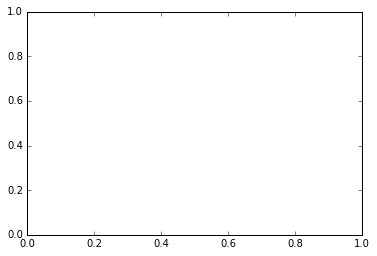

In [35]:
ax = plt.gca()
text = plt.Text(0, 0, "bla")

ax.add_line(text)   #autoscale works for this

ax.autoscale(True)